
---
title: "Time series with varying slopes"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Here, I am continuing a series of posts related to time-series data. The context, generated dataset, and varying intercepts approach is described in [this post](https://benslack19.github.io/data%20science/statistics/time-series-varying-intercepts/). I'll use that same generated data to see how partial pooling can apply to varying slopes. As before, I'll start with a Bayesian approach using pymc, followed by an example with statsmodels.

Goal
- run varying slopes with treatment
- run varying slopes with time
- with pymc and statsmodels
-  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
sns.set_context("talk")
sns.set_palette("colorblind")

In [81]:
%load_ext autoreload
%autoreload 2

In [82]:
from utils import draw_causal_graph, plot_comparison, standardize

In [3]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    Taken from: https://github.com/dustinstansbury/statistical-rethinking-2023/blob/a0f4f2d15a06b33355cf3065597dcb43ef829991/utils.py#L52-L66

    """
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [21]:
def plot_comparison(trace0, trace1, var, xlabel, ylabel, title=None):
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    # means
    ax0.scatter(
        az.summary(trace0, var_names=[var])["mean"],
        az.summary(trace1, var_names=[var])["mean"],
        facecolors="none",
        edgecolors="k",
    )
    ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
    ax0.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=f"{title}\n(mean)",
    )

    # SD
    ax1.scatter(
        az.summary(trace0, var_names=[var])["sd"],
        az.summary(trace1, var_names=[var])["sd"],
        facecolors="none",
        edgecolors="k",
    )
    ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
    ax1.set(
        xlabel=xlabel,
        ylabel=ylabel,
        title=f"{title}\n(standard deviation)",
    )
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle="dashed", color="gray")

    # Calculate the minimum and maximum of both x and y data
    data_min = min(
        min(az.summary(trace_m0, var_names=["a"])["sd"]),
        min(az.summary(trace_m1, var_names=["a"])["sd"]),
    )
    data_max = max(
        max(az.summary(trace_m0, var_names=["a"])["sd"]),
        max(az.summary(trace_m1, var_names=["a"])["sd"]),
    )

    # Set the limits to be the same for both axes
    ax1.set_xlim(data_min * 0.95, data_max * 1.05)
    ax1.set_ylim(data_min * 0.95, data_max * 1.05)

    f.tight_layout()

# Data generation and transformation

I'll skip the explanation here since it's in the previous post and run this code.

In [5]:
# Generate synthetic data
n_patients = 30
n_timepoints = 5

# Create patient IDs
patient_ids = np.repeat(np.arange(n_patients), n_timepoints)

# Create time points
time = np.tile(np.arange(n_timepoints), n_patients)

# Create patient-specific attributes (age and treatment)
age = np.random.randint(40, 70, n_patients)
treatment = np.random.binomial(1, 0.5, n_patients)

# Repeat age and treatment to match the longitudinal measurements
age_repeated = np.repeat(age, n_timepoints)
treatment_repeated = np.repeat(treatment, n_timepoints)

# Combine into a DataFrame
df_data = pd.DataFrame(
    {
        "patient_id": patient_ids,
        "time": time,
        "age": age_repeated,
        "treatment": treatment_repeated,
    }
)

# Use a generative model to create tumor size with some randomness
alpha_tumor_size = 50  # intercept term
bT = 1  # positive association for time
bA = 0.25  # positive association for age
bR = -5  # negative association for treatment

mu_tumor_size = (
    alpha_tumor_size
    + bT * df_data["time"]
    + bA * df_data["age"]
    + bR * df_data["treatment"]
)

sigma_tumor_size = 2

df_data["tumor_size"] = np.random.normal(mu_tumor_size, sigma_tumor_size)
df_data["tumor_size_std"] = standardize(df_data["tumor_size"])

df_data.head()

,patient_id,time,age,treatment,tumor_size,tumor_size_std
0,0,0,56,1,57.169997,-1.330882
1,0,1,56,1,57.757602,-1.182186
2,0,2,56,1,60.805338,-0.410946
3,0,3,56,1,59.342597,-0.781097
4,0,4,56,1,61.302079,-0.285244


# Varying slopes using pymc

Let's define the equation. We're going to assume the tumor size is Gaussian distributed. We know from the data generation process that tumor size is a linear combination of independent variables for time, age, and treatment, and that we can think of `patient_id` as a cluster variable with repeated measures. We used varying intercepts in the last post. Now let's think about adding a predictor. Let's just focus on treatment for now. I'll refer to $\beta_r$ as the coefficient for treatment. We'll keep our varying intercepts term. 

This will allow us to pool information about treatments across patients.

## Model 0: Varying intercepts and unpooled slopes

In this first model, we'll have unpooled slopes so we have a contrast to see how partial pooling helps.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{\text{pt[i]}} + \beta_{R, \text{pt[i]}}R_i $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\text{pt}}) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$
$$ \beta_{R,j} \sim \text{Normal}(0, 1) $$
$$ \sigma_{\text{pt}} \sim \text{Exponential}(1) $$
$$ \sigma \sim \text{Exponential}(1) $$


In [7]:
df_data.head()

,patient_id,time,age,treatment,tumor_size,tumor_size_std
0,0,0,56,1,57.169997,-1.330882
1,0,1,56,1,57.757602,-1.182186
2,0,2,56,1,60.805338,-0.410946
3,0,3,56,1,59.342597,-0.781097
4,0,4,56,1,61.302079,-0.285244


In [12]:
# multilevel model, random intercepts and unpooled slopes
with pm.Model() as m0:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # prior for SD of tumor size
    sigma = pm.Exponential("sigma", 1.0)

    # alpha, beta priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))
    bR = pm.Normal("bR", 0, 1, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]] + bR[df_data["patient_id"]] * df_data["treatment"]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m0 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_pt, sigma, a, bR]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


In [13]:
az.summary(trace_m0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.126,0.493,-0.824,1.002,0.009,0.008,3355.0,2358.0,1.0
a[1],0.542,0.266,0.036,1.026,0.003,0.003,7629.0,2535.0,1.0
a[2],0.089,0.485,-0.822,0.993,0.009,0.007,2932.0,2353.0,1.0
a[3],0.304,0.470,-0.568,1.218,0.008,0.006,3891.0,3206.0,1.0
a[4],0.613,0.267,0.116,1.110,0.003,0.002,8500.0,2739.0,1.0
...,...,...,...,...,...,...,...,...,...
bR[27],-0.417,0.526,-1.415,0.552,0.008,0.006,4167.0,2657.0,1.0
bR[28],-1.246,0.536,-2.224,-0.227,0.009,0.006,3752.0,2852.0,1.0
bR[29],-0.005,1.037,-1.945,2.003,0.011,0.022,9722.0,2474.0,1.0
sigma,0.707,0.047,0.617,0.795,0.001,0.000,4850.0,2704.0,1.0


## Model 1: Varying intercepts and varying slopes

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{\text{pt[i]}} + \beta_{\text{pt[i]}}R_i $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha, \text{pt}}) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$
$$ \beta_j \sim \text{Normal}(\bar{\beta}, \sigma_{\beta, \text{pt}}) $$
$$ \bar{\beta} \sim \text{Normal}(0,1) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \sigma_{\alpha, \text{pt}} \sim \text{Exponential}(1) $$
$$ \sigma_{\beta, \text{pt}} \sim \text{Exponential}(1) $$


In [14]:
# multilevel model, random intercepts and random slopes
with pm.Model() as m1:

    # hyperpriors for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b_bar = pm.Normal("b_bar", 0.0, 1)
    sigma_b = pm.Exponential("sigma_b", 1.0)

    # prior for SD of tumor size
    sigma = pm.Exponential("sigma_pt", 1.0)

    # alpha, beta priors for each patient
    a = pm.Normal("a", a_bar, sigma_a, shape=len(df_data["patient_id"].unique()))
    bR = pm.Normal("bR", b_bar, sigma_b, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]] + bR[df_data["patient_id"]] * df_data["treatment"]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, b_bar, sigma_b, sigma_pt, a, bR]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
There were 396 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
az.summary(trace_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.465,0.309,-0.131,1.014,0.012,0.008,659.0,1537.0,1.02
a[1],0.593,0.250,0.107,1.074,0.014,0.013,326.0,169.0,1.01
a[2],0.370,0.306,-0.244,0.932,0.011,0.008,818.0,2200.0,1.01
a[3],0.905,0.333,0.269,1.510,0.017,0.013,389.0,998.0,1.02
a[4],0.649,0.238,0.189,1.088,0.006,0.004,1476.0,2320.0,1.01
...,...,...,...,...,...,...,...,...,...
bR[29],-1.165,0.336,-1.795,-0.504,0.013,0.009,510.0,1247.0,1.01
b_bar,-1.164,0.194,-1.504,-0.787,0.013,0.009,233.0,550.0,1.04
sigma_a,0.394,0.097,0.213,0.570,0.005,0.003,428.0,920.0,1.03
sigma_b,0.232,0.144,0.046,0.493,0.016,0.011,53.0,32.0,1.06


## Comparison of estimates with no pooling, partial pooling


We'll now be able to look at how the two models outputted estimates for varying intercepts and varying slopes. Let's start with varying intercepts. Remember

/Users/benlacar/benslack19.github.io/_posts_drafts/utils.py:115: SyntaxWarning: invalid escape sequence '\c'
  )
/Users/benlacar/benslack19.github.io/_posts_drafts/utils.py:116: SyntaxWarning: invalid escape sequence '\c'
  


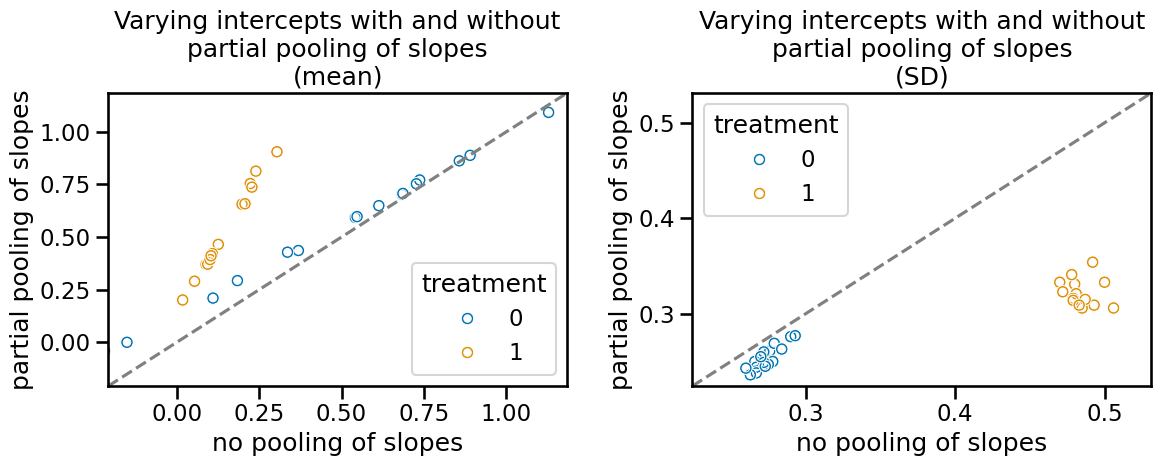

In [110]:
plot_comparison(
    trace_m0,
    trace_m1,
    var_name="a",
    meta_df=df_data,
    cluster_col="patient_id",
    hue="treatment",
    xlabel="no pooling of slopes",
    ylabel="partial pooling of slopes",
    title_prefix="Varying intercepts with and without\npartial pooling of slopes",
)

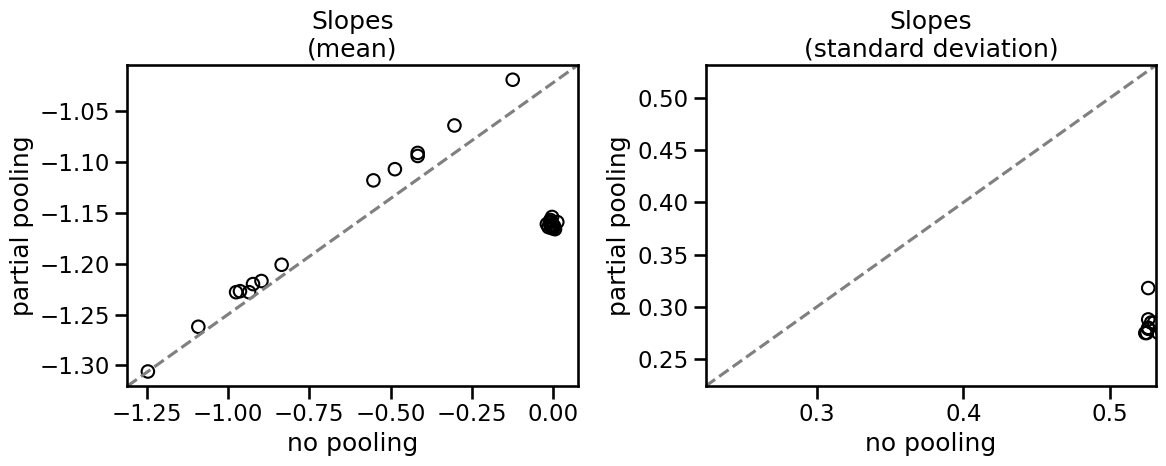

In [16]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# means
ax0.scatter(
    az.summary(trace_m0, var_names=["bR"])["mean"],
    az.summary(trace_m1, var_names=["bR"])["mean"],
    facecolors="none",
    edgecolors="k",
)
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax0.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="Slopes\n(mean)",
)

# SD
ax1.scatter(
    az.summary(trace_m0, var_names=["bR"])["sd"],
    az.summary(trace_m1, var_names=["bR"])["sd"],
    facecolors="none",
    edgecolors="k",
)
ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax1.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="Slopes\n(standard deviation)",
)
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle="dashed", color="gray")

# Calculate the minimum and maximum of both x and y data
data_min = min(
    min(az.summary(trace_m0, var_names=["a"])["sd"]),
    min(az.summary(trace_m1, var_names=["a"])["sd"]),
)
data_max = max(
    max(az.summary(trace_m0, var_names=["a"])["sd"]),
    max(az.summary(trace_m1, var_names=["a"])["sd"]),
)

# Set the limits to be the same for both axes
ax1.set_xlim(data_min * 0.95, data_max * 1.05)
ax1.set_ylim(data_min * 0.95, data_max * 1.05)

f.tight_layout()

You can see that partial pooling decreases the standard error of the intercept parameter in most cases, even though the mean estimate does not really change. Let's see how to implement this in statsmodels.

# Using statsmodels

Using probabilistic programming provides a nice framework to get the random intercepts with probability distributions. But it may not scale as well. Let's explore varying intercepts using statsmodels.

## Varying intercept model

In [26]:
# Define the mixed-effects model formula with only varying intercepts
model = smf.mixedlm("tumor_size_std ~ 1", df_data, groups=df_data["patient_id"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 150     Method:             REML          
No. Groups:       30      Scale:              0.4754        
Min. group size:  5       Log-Likelihood:     -186.1971     
Max. group size:  5       Converged:          Yes           
Mean group size:  5.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.000     0.146  -0.000  1.000  -0.287   0.287
Group Var      0.546     0.272                               



The main thing we want to look at is the bottom of the table. `Intercept` refers to the population's average ($\bar{\alpha}$ while `Group Var` refers to the variance of the random intercepts associated with the grouping variable (`patient_id`) which is `sigma_pt` in the `pymc` model. We can see that these are largely in alignment with the `pymc` results even if `Group Var`/`sigma_pt` differ in their means.

In [54]:
az.summary(trace_m2, var_names=["a_bar", "sigma_pt"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.003,0.150,-0.286,0.284,0.002,0.002,6844.0,3590.0,1.0
sigma_pt,0.759,0.121,0.538,0.981,0.002,0.001,5584.0,3368.0,1.0


# Comparing `pymc` and `statsmodels` output

Now let's see how each individual patient's estimates look between `pymc` and `statsmodels`. Statsmodels doesn't provide the SD directly. It may be derived by bootstrapping but we'll ignore this for now.

In [42]:
# Extract the random effects
df_smf_random_effects = (
    pd.DataFrame(result.random_effects)
    .T.reset_index()
    .rename(columns={"index": "Patient", "Group": "random_effect_mean"})
)

df_smf_random_effects.head()

,Patient,random_effect_mean
0,0,0.237706
1,1,-0.603279
2,2,0.358260
3,3,0.775414
4,4,0.398535


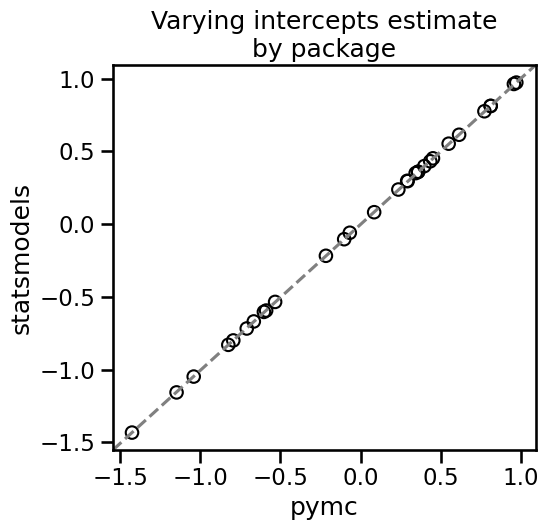

In [55]:
f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(1, 2, 1)

ax.scatter(
    az.summary(trace_m2, var_names=["a"])["mean"],
    df_smf_random_effects["random_effect_mean"],
    facecolors="none",
    edgecolors="k",
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="dashed", color="gray")
ax.set(
    xlabel="pymc",
    ylabel="statsmodels",
    title="Varying intercepts estimate\nby package",
);

As we can see, the two packages give essentially the same results for varying intercepts.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue May 28 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pymc       : 5.15.0
graphviz   : 0.20.3
seaborn    : 0.13.2
matplotlib : 3.8.4
statsmodels: 0.14.2
scipy      : 1.13.0
numpy      : 1.26.4
pandas     : 2.2.2
arviz      : 0.18.0

Watermark: 2.4.3

